# March Machine Learning Mania 2024 – Ensemble Model

This notebook builds an optimized ensemble of three machine learning models to predict NCAA basketball tournament outcomes:

* **Logistic Regression** - A linear model for probabilistic classification
* **Random Forest** - An ensemble of decision trees
* **XGBoost** - A gradient boosting algorithm

We'll find optimal weights for combining these models by minimizing the **Brier score** (mean-squared error between predicted probabilities and true outcomes), which is the official evaluation metric for the Kaggle competition.

The final ensemble will be used to generate tournament predictions and bracket simulations.

In [1]:
# Global user-tweakable constants
MEN_BRACKETS    = 50000     # how many men's brackets to simulate (1…100 000)
WOMEN_BRACKETS  = 50000     # how many women's brackets to simulate
GRID_STEP       = 0.02     # simplex granularity for weight search
PLOT_STYLE      = 'ggplot' # any Matplotlib style you like

# ---------------------------------------------------------------
import os, sys, random, itertools, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(PLOT_STYLE)

if os.path.exists('/kaggle/input'):
    sys.path.append('/kaggle/input/preprocessing-module')
else:
    sys.path.append('../../scripts')
    
from pre_processing import get_y_true

from sklearn.metrics import brier_score_loss

In [2]:
def resolve_paths():
    """Return (data_dir, preds_dir, output_dir) depending on runtime."""
    if os.path.exists('/kaggle/input'):
        data_dir  = Path('/kaggle/input/march-machine-learning-mania-2024')
        preds_dir = Path('/kaggle/input/predictions')
        out_dir   = Path('/kaggle/working')
    else:
        project   = Path.cwd().resolve().parent.parent
        data_dir  = project / 'data' / 'march-machine-learning-mania-2024'
        preds_dir = project / 'predictions'
        out_dir   = project
    out_dir.mkdir(exist_ok=True, parents=True)
    return data_dir, preds_dir, out_dir


def load_predictions(years, models=('lr', 'rf', 'xgb'), preds_dir=Path('.')):
    """Concatenate prediction CSVs for the requested seasons."""
    frames = []
    for season in years:
        dfs = []
        for m in models:
            f = preds_dir / f'predictions_{season}_{m}.csv'
            if not f.exists():
                print(f'Warning – missing file: {f}')
                continue
            df = pd.read_csv(f)
            prob_col = 'y_hat_proba' if 'y_hat_proba' in df.columns else df.columns[-1]
            df      = df.rename(columns={prob_col: m})
            if 'ID' in df.columns and 'GameID' not in df.columns:
                df = df.rename(columns={'ID': 'GameID'})
            df['Season'] = season
            dfs.append(df[['Season', 'GameID', m]])
        if dfs:
            merged = dfs[0]
            for t in dfs[1:]:
                merged = merged.merge(t, on=['Season', 'GameID'])
            frames.append(merged)
    if not frames:
        raise FileNotFoundError('No prediction files found.')
    return pd.concat(frames, ignore_index=True)


## 1 Inspect base‑model calibration
Before stacking, we want a feel for how each model performs in isolation. A well‑calibrated probability model has a Brier score close to what you'd expect from log‑loss parity.

We'll look at 2022 & 2023 hold‑out seasons, the same data we'll later use for weight optimisation.

Games with outcome available: 268


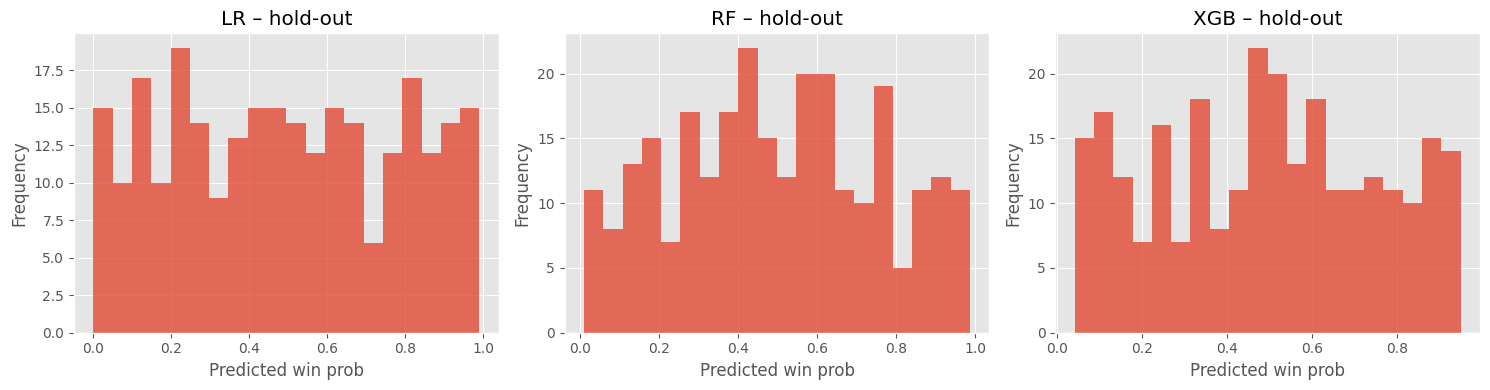

lr    Brier = 0.19027
rf    Brier = 0.19103
xgb   Brier = 0.18833


In [3]:
random.seed()  # Initialize with system time
np.random.seed()  # Initialize with system time

data_dir, preds_dir, out_dir = resolve_paths()
models        = ['lr', 'rf', 'xgb']
holdout_years = [2022, 2023]

preds = load_predictions(holdout_years, models=models, preds_dir=preds_dir)

# Attach ground-truth labels (NaN for games never played)
truth = get_y_true(preds[['Season', 'GameID']])
preds = preds.merge(truth, on=['Season', 'GameID'], how='left')
eval_df = preds.dropna(subset=['y_true'])

print(f'Games with outcome available: {len(eval_df)}')

# Histogram of probability calibration ---------------------------
plt.figure(figsize=(15,4))
for i, m in enumerate(models, 1):
    plt.subplot(1, 3, i)
    plt.hist(eval_df[m], bins=20, alpha=0.8)
    plt.title(f'{m.upper()} – hold-out')
    plt.xlabel('Predicted win prob')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Keep only binary outcomes
eval_df = eval_df[eval_df['y_true'].isin([0, 1])]

# Individual Brier scores ----------------------------------------
for m in models:
    score = brier_score_loss(eval_df['y_true'], eval_df[m])
    print(f'{m:<4s}  Brier = {score:.5f}')


## 2 Search for optimal ensemble weights
We explore two complementary strategies:

1. **Fine‑grid search** on a 0.02 simplex step (\~8 000 combos).
2. **Bayesian optimisation** (optional, uses `scikit‑optimize` if installed) which can find near‑optimal weights in a few dozen evaluations.

Feel free to comment out whichever you don't want.

Best weights (np.float64(0.3), np.float64(0.0), np.float64(0.7))  Brier 0.187930


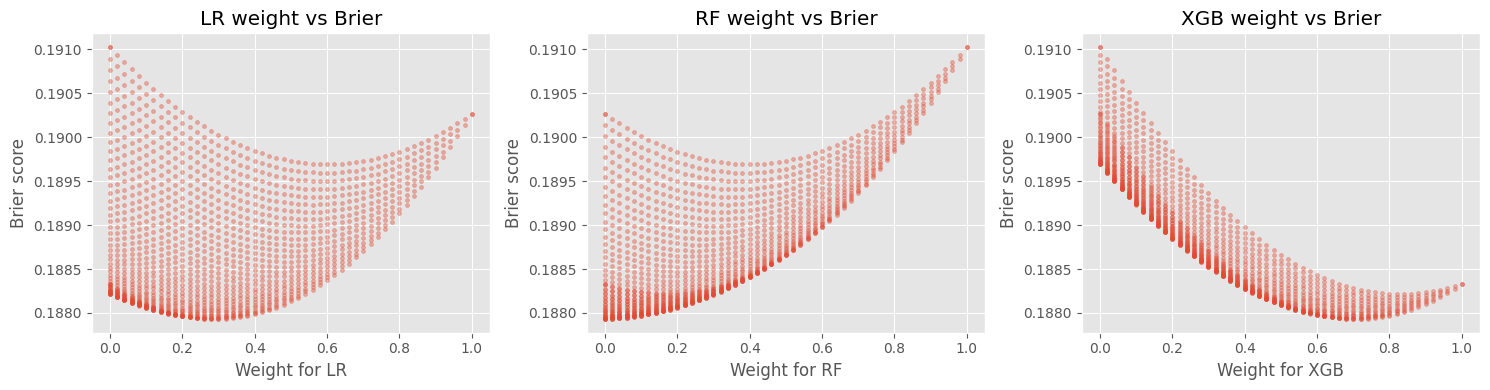

In [4]:
def simplex_grid(n_models, step=GRID_STEP):
    if n_models == 2:
        rng = np.arange(0, 1+1e-9, step)
        for w1 in rng:
            yield (round(w1,3), round(1-w1,3))
    elif n_models == 3:
        rng = np.arange(0, 1+1e-9, step)
        for w1, w2 in itertools.product(rng, repeat=2):
            w3 = 1 - w1 - w2
            if w3 < -1e-9:           # outside simplex
                continue
            yield (round(w1,3), round(w2,3), round(round(w3,3), 3))

def grid_search(weights_iter, df, model_cols):
    best_w, best_bs = None, 1e9
    results = []
    for w in weights_iter:
        ens = np.zeros(len(df))
        for wi, m in zip(w, model_cols):
            ens += wi * df[m].values
        bs = brier_score_loss(df['y_true'], ens)
        results.append((w, bs))
        if bs < best_bs:
            best_w, best_bs = w, bs
    return best_w, best_bs, sorted(results, key=lambda x: x[1])


# Search space (3 corner cases added for clarity) -----------------
corner_3 = [(1,0,0), (0,1,0), (0,0,1)]
weights_iter = itertools.chain(simplex_grid(3, GRID_STEP), corner_3)

best_w, best_bs, rank = grid_search(weights_iter, eval_df, models)
print(f'Best weights {best_w}  Brier {best_bs:.6f}')

# Weight-vs-Brier scatter (first 2 000 combos)
top = rank[:2000]
brier_vals = [r[1] for r in top]

plt.figure(figsize=(15,4))
for i, m in enumerate(models):
    weights_i = [r[0][i] for r in top]
    ax = plt.subplot(1, 3, i+1)
    ax.scatter(weights_i, brier_vals, s=8, alpha=0.4)
    ax.set_xlabel(f'Weight for {m.upper()}')
    ax.set_ylabel('Brier score')
    ax.set_title(f'{m.upper()} weight vs Brier')
    ax.grid(True)
plt.tight_layout()
plt.show()

In [5]:
# --- build ensemble probabilities for 22-23 hold-out ----------
eval_df['ensemble'] = 0.0
for w, m in zip(best_w, models):
    eval_df['ensemble'] += w * eval_df[m]

## 3 Build 2024 ensemble & save submission

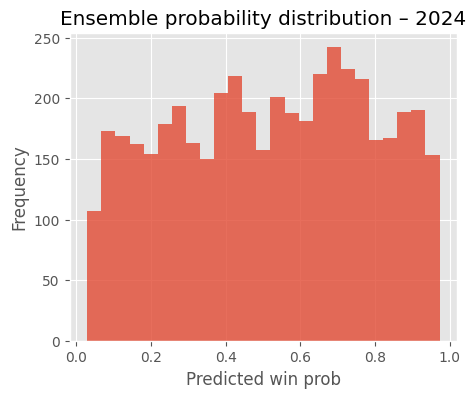

In [6]:
test_season = 2024
test_df     = load_predictions([test_season], models=models, preds_dir=preds_dir)
test_df['y_hat_proba'] = 0.0
for w, m in zip(best_w, models):
    test_df['y_hat_proba'] += w * test_df[m]

plt.figure(figsize=(5,4))
plt.hist(test_df['y_hat_proba'], bins=25, alpha=0.8)
plt.title('Ensemble probability distribution – 2024')
plt.xlabel('Predicted win prob')
plt.ylabel('Frequency')
plt.show()

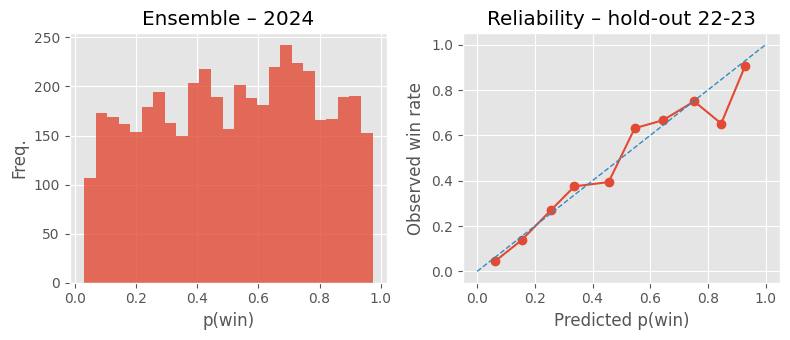

In [13]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# reliability uses 22-23 hold-out
prob  = eval_df['ensemble'].values
true  = eval_df['y_true'].values
frac_pos, mean_pred = calibration_curve(true, prob, n_bins=10, strategy='uniform')

fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))

# left panel – reuse 2024 probabilities just computed in Cell C
ax[0].hist(test_df['y_hat_proba'], bins=25, alpha=0.8)
ax[0].set_title('Ensemble – 2024')
ax[0].set_xlabel('p(win)')
ax[0].set_ylabel('Freq.')

# right panel – reliability 22-23
ax[1].plot(mean_pred, frac_pos, marker='o')
ax[1].plot([0, 1], [0, 1], '--', linewidth=1)
ax[1].set_title('Reliability – hold-out 22-23')
ax[1].set_xlabel('Predicted p(win)')
ax[1].set_ylabel('Observed win rate')

plt.tight_layout()
plt.show()

## 4 Generate Tournament Brackets

Now we'll use our calibrated ensemble model to simulate brackets for the NCAA tournament. The simulation process:

1. Loads the tournament structure (seeds and slots)
2. Creates a probability lookup table from our model predictions
3. Runs Monte Carlo simulations to generate thousands of plausible brackets
4. Formats the output for Kaggle submission

In [8]:
from zipfile import ZipFile
from tqdm.notebook import tqdm

def load_bracket_assets(season, data_dir):
    """
    Return (seeds, slots) for the chosen season.
    Supports data_dir as either:
      – a directory containing the CSVs, or
      – a .zip archive named <data_dir>.zip (or data_dir itself is .zip)
    """
    def read_df(fname):
        # 1) Try CSV on disk
        path = data_dir / fname
        if path.exists():
            return pd.read_csv(path)
        # 2) Fallback: open from zip
        #    data_dir.zip  or data_dir itself if it's .zip
        if data_dir.is_file() and data_dir.suffix == '.zip':
            zip_path = data_dir
        else:
            zip_path = data_dir.with_suffix('.zip')
        if not zip_path.exists():
            raise FileNotFoundError(f"Couldn't find {fname} in {data_dir} or {zip_path}")
        with ZipFile(zip_path, 'r') as z:
            with z.open(fname) as f:
                return pd.read_csv(f)

    # Load seeds for the current season (men's and women's)
    tourney_seeds = read_df('2024_tourney_seeds.csv')
    seeds_m = tourney_seeds[tourney_seeds['Tournament'] == 'M']
    seeds_w = tourney_seeds[tourney_seeds['Tournament'] == 'W']
    
    # Load slots data (men's and women's)
    m_slots = read_df('MNCAATourneySlots.csv')
    m_slots = m_slots[m_slots['Season'] == season]
    m_slots = m_slots[m_slots['Slot'].str.contains('R')]  # Filter out First Four games
    
    w_slots = read_df('WNCAATourneySlots.csv')
    w_slots = w_slots[w_slots['Season'] == season]
    w_slots = w_slots[w_slots['Slot'].str.contains('R')]  # Filter out First Four games
    
    return seeds_m, seeds_w, m_slots, w_slots


def prepare_data(seeds, ensemble_preds):
    """
    Prepare data for bracket simulation
    
    Parameters:
    - seeds: DataFrame containing seed information
    - ensemble_preds: DataFrame with our ensemble predictions
    
    Returns:
    - seed_dict: Dictionary mapping seed values to team IDs
    - inverted_seed_dict: Dictionary mapping team IDs to seed values
    - probas_dict: Dictionary containing matchup probabilities keyed by teams
    - gameids_dict: Dictionary mapping team pairs to GameIDs
    - predictions_dict: Dictionary mapping GameIDs to win probabilities
    """
    # Create seed to TeamID mapping
    seed_dict = seeds.set_index('Seed')['TeamID'].to_dict()
    # Create reverse mapping from TeamID to seed
    inverted_seed_dict = {value: key for key, value in seed_dict.items()}
    
    # Extract team IDs from GameID using our convention
    ensemble_preds['Team1ID'] = ((ensemble_preds['GameID'] // 10_000) % 10_000).astype(int)
    ensemble_preds['Team2ID'] = (ensemble_preds['GameID'] % 10_000).astype(int)
    
    # Create GameID lookup dict for every possible team1-team2 pair
    gameids_dict = {}
    # Create probability lookup dictionary keyed by GameID
    predictions_dict = {}
    
    for _, row in ensemble_preds.iterrows():
        team1, team2 = row['Team1ID'], row['Team2ID']
        game_id = row['GameID']
        proba = row['y_hat_proba']
        
        # Store this game ID for the team matchup
        gameids_dict[(team1, team2)] = game_id
        # Store probability prediction for this game ID
        predictions_dict[game_id] = proba
    
    # Traditional lookup dict for compatibility with existing code
    probas_dict = {}
    for _, row in ensemble_preds.iterrows():
        team1, team2 = row['Team1ID'], row['Team2ID']
        team1_str, team2_str = str(team1), str(team2)
        # Probability of Team1 beating Team2
        proba = row['y_hat_proba']
        
        # Store both directions for easy lookup
        probas_dict.setdefault(team1_str, {})[team2_str] = proba
        probas_dict.setdefault(team2_str, {})[team1_str] = 1 - proba
    
    return seed_dict, inverted_seed_dict, probas_dict, gameids_dict, predictions_dict


def simulate(round_slots, seeds, inverted_seeds, probas, gameids_dict, predictions_dict, random_values, sim=True):
    '''
    Simulates each round of the tournament.

    Parameters:
    - round_slots: DataFrame containing information on who is playing in each round.
    - seeds (dict): Dictionary mapping seed values to team IDs.
    - inverted_seeds (dict): Dictionary mapping team IDs to seed values.
    - probas (dict): Dictionary containing matchup probabilities (legacy format).
    - gameids_dict (dict): Dictionary mapping team pairs to GameIDs.
    - predictions_dict (dict): Dictionary mapping GameIDs to win probabilities.
    - random_values (array-like): Array with precomputed random-values.
    - sim (boolean): Simulates match if True. Chooses team with higher probability as winner otherwise.

    Returns:
    - list: List with winning team seeds for each match.
    - list: List with corresponding slot names for each match.
    '''
    winners = []
    slots = []
    seeds_working = seeds.copy()  # Create a working copy to avoid modifying the original

    for slot, strong, weak, random_val in zip(round_slots.Slot, round_slots.StrongSeed, round_slots.WeakSeed, random_values):
        # Get team IDs for the matchup
        team1 = seeds_working.get(strong, None)
        team2 = seeds_working.get(weak, None)

        # Skip if teams aren't available yet (should not happen with proper ordering)
        if team1 is None or team2 is None:
            continue
            
        # Try to find this matchup in our gameids_dict
        game_id = gameids_dict.get((team1, team2), None)
        if game_id is not None:
            # We have a prediction for team1 vs team2
            proba = predictions_dict.get(game_id)
        else:
            # Try the reverse matchup
            game_id = gameids_dict.get((team2, team1), None)
            if game_id is not None:
                # Invert the probability as we're now considering team1's chance against team2
                proba = 1 - predictions_dict.get(game_id)
            else:
                # Print warning instead of using fallback
                print(f"WARNING: No prediction found for matchup between TeamID {team1} and TeamID {team2} in slot {slot}")
                # Default to 50% if no prediction available
                proba = 0.5
        
        # Simulate the outcome or pick the most likely winner
        if sim:
            # Randomly determine the winner based on the probability
            winner = team1 if random_val < proba else team2
        else:
            # Determine the winner based on the higher probability
            winner = team1 if proba >= 0.5 else team2
            
        # Append the winner and corresponding slot to the lists
        winners.append(winner)
        slots.append(slot)

        # Update seeds dictionary with the winner for the next rounds
        seeds_working[slot] = winner

    # Convert winners to original seeds using the inverted_seeds dictionary
    return [inverted_seeds[w] for w in winners], slots


def run_simulation(brackets=1, seeds=None, ensemble_preds=None, round_slots=None, sim=True):
    '''
    Runs a simulation of bracket tournaments using ensemble predictions.

    Parameters:
    - brackets (int): Number of brackets to simulate.
    - seeds (pd.DataFrame): DataFrame containing seed information.
    - ensemble_preds (pd.DataFrame): DataFrame containing our ensemble predictions.
    - round_slots (pd.DataFrame): DataFrame containing tournament structure information.
    - sim (boolean): Whether to simulate matches or pick highest probability winner.

    Returns:
    - pd.DataFrame: DataFrame with simulation results.
    '''
    # Prepare data for simulation
    seed_dict, inverted_seed_dict, probas_dict, gameids_dict, predictions_dict = prepare_data(seeds, ensemble_preds)
    
    # Lists to store simulation results
    results = []
    bracket_ids = []
    slot_names = []
    
    # Precompute random values for all brackets
    random_values = np.random.random(size=(brackets, len(round_slots)))

    # Run simulations for the specified number of brackets
    for b in tqdm(range(1, brackets+1)):
        # Run a single simulation
        bracket_results, bracket_slots = simulate(
            round_slots, seed_dict, inverted_seed_dict, probas_dict, 
            gameids_dict, predictions_dict, random_values[b-1], sim
        )
        
        # Store results
        results.extend(bracket_results)
        bracket_ids.extend([b] * len(bracket_results))
        slot_names.extend(bracket_slots)

    # Create DataFrame with simulation results
    result_df = pd.DataFrame({'Bracket': bracket_ids, 'Slot': slot_names, 'Team': results})
    return result_df

In [9]:
# Set truly random seeds
np.random.seed(None)
random.seed(None)

# Load tournament structure data for 2024
seeds_m, seeds_w, m_slots, w_slots = load_bracket_assets(test_season, data_dir)

# Simulate MEN_BRACKETS men's brackets
print(f"Simulating {MEN_BRACKETS} men's brackets...")
result_m = run_simulation(brackets=MEN_BRACKETS, 
                         seeds=seeds_m, 
                         ensemble_preds=test_df, 
                         round_slots=m_slots,
                         sim=True)
result_m['Tournament'] = 'M'

# Simulate WOMEN_BRACKETS women's brackets
print(f"Simulating {WOMEN_BRACKETS} women's brackets...")
result_w = run_simulation(brackets=WOMEN_BRACKETS, 
                         seeds=seeds_w, 
                         ensemble_preds=test_df, 
                         round_slots=w_slots,
                         sim=True)
result_w['Tournament'] = 'W'

# Combine men's and women's brackets and format for submission
submission = pd.concat([result_m, result_w])
submission = submission[['Bracket', 'Tournament', 'Slot', 'Team']]  # Reorder columns to match expected format
submission.reset_index(inplace=True)
submission.rename(columns={'index': 'RowId'}, inplace=True)
submission['RowId'] += 1  # Make RowId 1-based instead of 0-based

# Final format: RowId, Tournament, Bracket, Slot, Team
submission = submission[['RowId', 'Tournament', 'Bracket', 'Slot', 'Team']]

# Define path for potential future use, but don't save the file yet
csv_path = out_dir / 'submission.csv'
print(f"Created {MEN_BRACKETS} men's and {WOMEN_BRACKETS} women's brackets (in memory)")

# Show bracket counts per tournament
print("\nBracket counts:")
print(submission.groupby('Tournament')['Bracket'].nunique())

Simulating 50000 men's brackets...


  0%|          | 0/50000 [00:00<?, ?it/s]

Simulating 50000 women's brackets...


  0%|          | 0/50000 [00:00<?, ?it/s]

Created 50000 men's and 50000 women's brackets (in memory)

Bracket counts:
Tournament
M    50000
W    50000
Name: Bracket, dtype: int64


## 5 Analysis of Simulation Results

Now that we've generated tournament brackets using our ensemble model, let's analyze the results:

1. **Distribution of winners** - Which teams are most frequently predicted to win the tournament
2. **Upset probability** - Likelihood of lower-seeded teams advancing in each round
3. **Path difficulty** - Analyze which teams have the most challenging predicted paths

These insights can help identify value bets and potential bracket vulnerabilities.

Brackets per tournament:
Tournament
M    50000
W    50000
Name: Bracket, dtype: int64


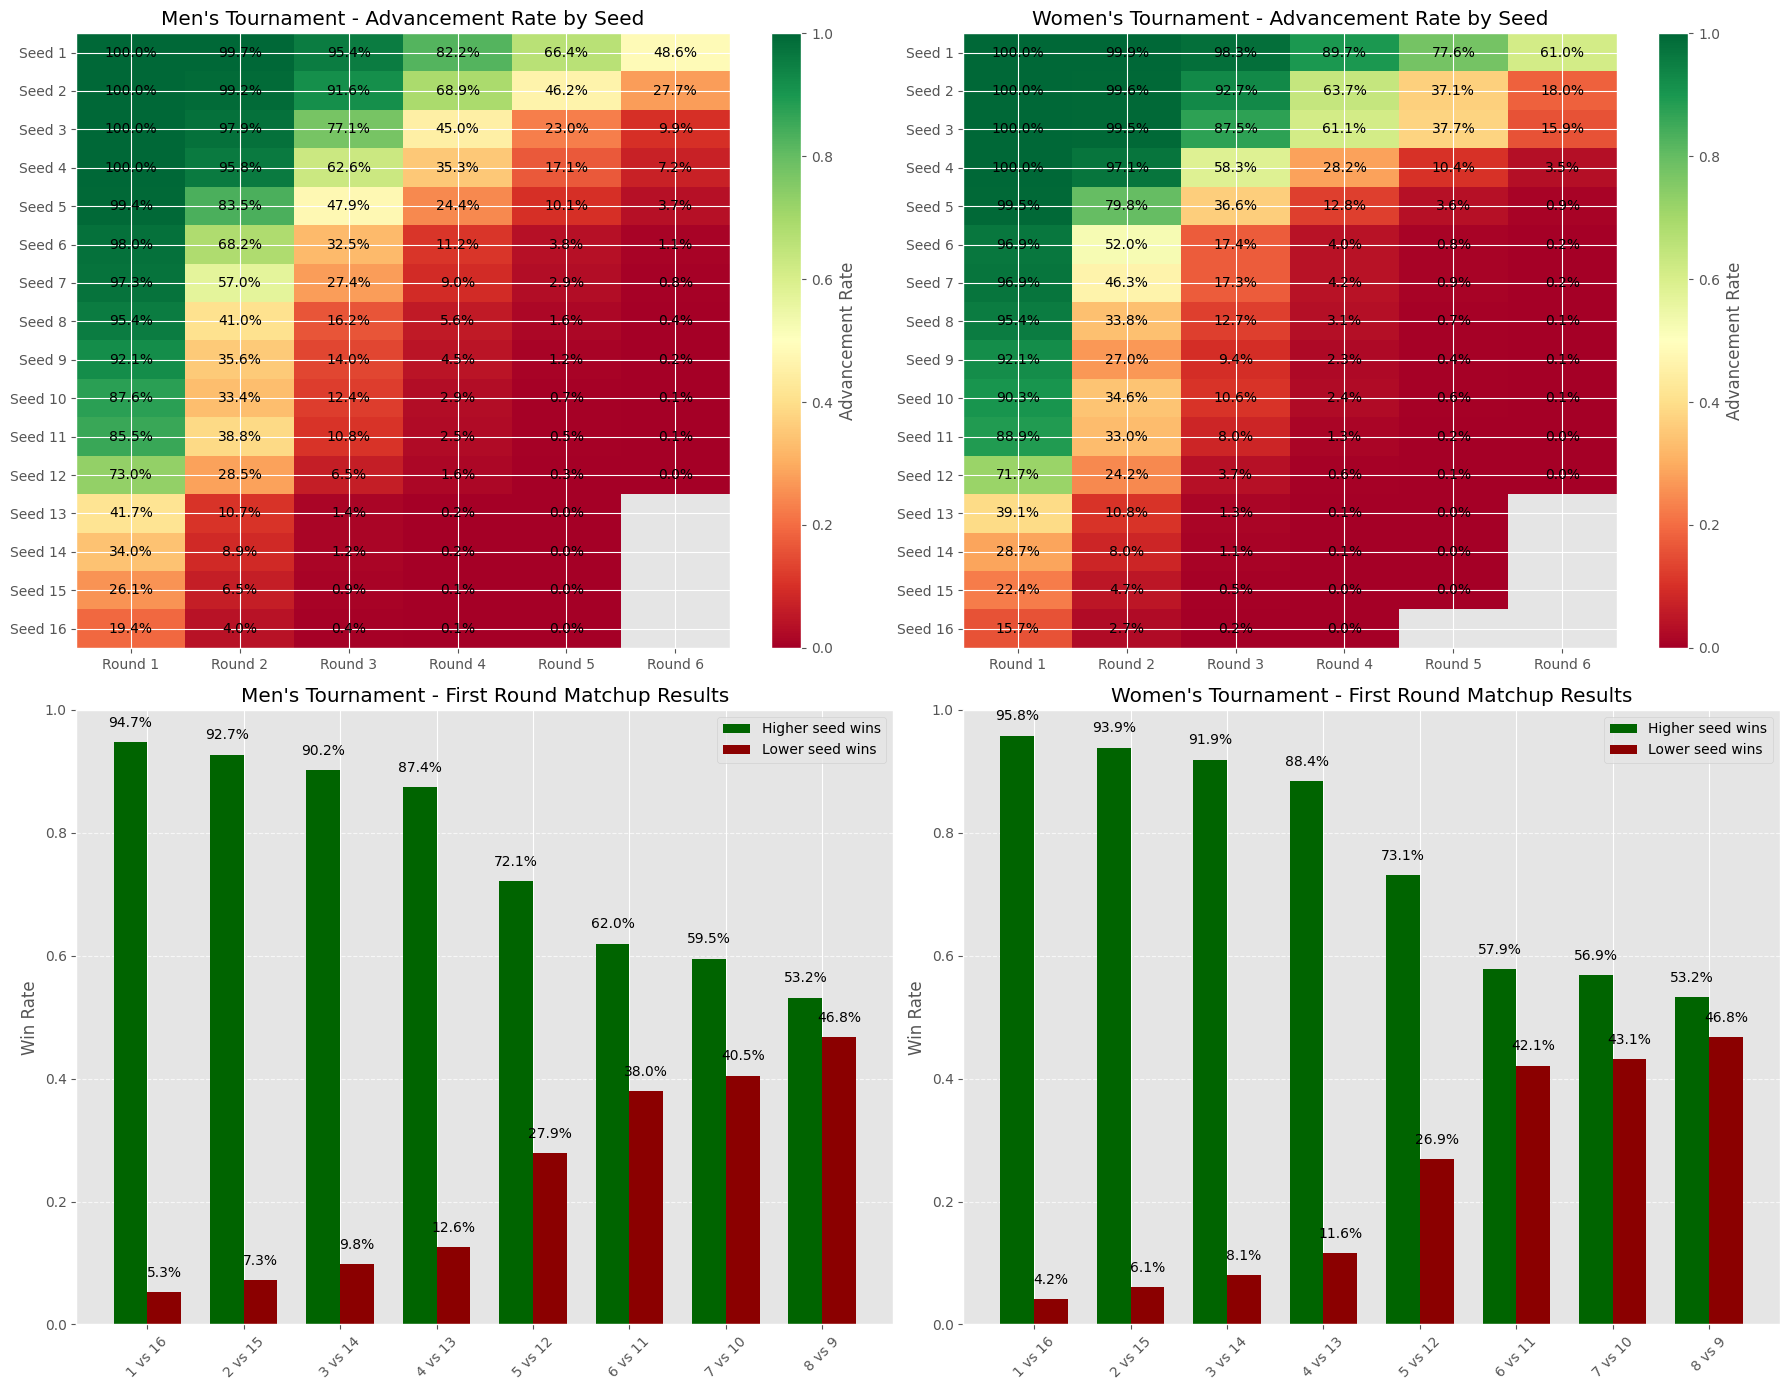

In [10]:
# how many unique brackets per tournament
print("Brackets per tournament:")
print(submission.groupby('Tournament')['Bracket'].nunique())

# Extract seed numbers for analysis (removing the region letter)
submission['SeedNumber'] = submission['Team'].str[1:].astype(int)

# Extract round information
submission['Round'] = submission['Slot'].str.extract(r'R(\d)').iloc[:,0].astype(int)

# Analyze Men's and Women's tournaments separately
tournaments = ['M', 'W']
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

for i, tournament in enumerate(tournaments):
    # Filter for this tournament
    tourney_data = submission[submission['Tournament'] == tournament]
    
    # First visualization: Advancement rate - how often each seed appears in each round
    seed_adv = (
        tourney_data
        .groupby(['Round', 'SeedNumber', 'Bracket'])
        .size()
        .reset_index(name='count')
        .groupby(['Round', 'SeedNumber'])
        .size()
        .reset_index(name='wins')
    )
    
    # Calculate by regions (each seed appears 4 times in Round 1)
    # Count how many regions have this seed in each round
    total_brackets = MEN_BRACKETS if tournament == 'M' else WOMEN_BRACKETS
    seed_adv['possible'] = total_brackets * 4 if seed_adv['Round'].eq(1).all() else total_brackets
    seed_adv.loc[seed_adv['Round'] > 1, 'possible'] = total_brackets
    
    # Calculate advancement rate
    seed_adv['advance_rate'] = np.minimum(seed_adv['wins'] / seed_adv['possible'], 1.0)
    
    # Pivot for easier plotting
    pivot_data = seed_adv.pivot(index='SeedNumber', columns='Round', values='advance_rate')
    
    # Plot heatmap
    cmap = plt.colormaps['RdYlGn']
    ax = axes[0, i]
    
    im = ax.imshow(pivot_data, cmap=cmap, aspect='auto', vmin=0, vmax=1)
    
    # Add round labels (columns)
    ax.set_xticks(np.arange(len(pivot_data.columns)))
    ax.set_xticklabels([f'Round {r}' for r in pivot_data.columns])
    
    # Add seed labels (rows)
    ax.set_yticks(np.arange(len(pivot_data.index)))
    ax.set_yticklabels([f'Seed {s}' for s in pivot_data.index])
    
    # Add text annotations with percentages
    for j in range(len(pivot_data.index)): 
        for k in range(len(pivot_data.columns)): 
            if not np.isnan(pivot_data.iloc[j, k]): 
                text = ax.text(k, j, f'{pivot_data.iloc[j, k]:.1%}', 
                             ha="center", va="center", color="black")
    
    # Add colorbar
    plt.colorbar(im, ax=ax, label='Advancement Rate')
    
    # Add title
    title = "Men's Tournament" if tournament == 'M' else "Women's Tournament"
    ax.set_title(f"{title} - Advancement Rate by Seed")
    
    # Second visualization: Win rate by seed in head-to-head matchups
    # Get all first-round matches and calculate win rates
    first_round = tourney_data[tourney_data['Slot'].str.contains('R1')]
    
    # Create a table showing each matchup result
    matchup_results = pd.DataFrame()
    for seed_pair in [(1,16), (2,15), (3,14), (4,13), (5,12), (6,11), (7,10), (8,9)]:
        high_seed, low_seed = seed_pair
        
        # Find results for this seed matchup in first round
        high_seed_wins = first_round[(first_round['SeedNumber'] == high_seed)].shape[0]
        low_seed_wins = first_round[(first_round['SeedNumber'] == low_seed)].shape[0]
        
        # Each bracket has 4 regions, so divide by total brackets
        high_seed_win_rate = high_seed_wins / (total_brackets * 4)
        low_seed_win_rate = low_seed_wins / (total_brackets * 4)
        
        # Add to results
        new_row = pd.DataFrame({
            'Matchup': [f"{high_seed} vs {low_seed}"],
            'HighSeed': [high_seed],
            'LowSeed': [low_seed],
            'HighSeedWinRate': [high_seed_win_rate],
            'LowSeedWinRate': [low_seed_win_rate]
        })
        matchup_results = pd.concat([matchup_results, new_row], ignore_index=True)
    
    # Plot matchup win rates
    ax = axes[1, i]
    
    # Create bar chart
    x = np.arange(len(matchup_results))
    width = 0.35
    
    high_bars = ax.bar(x - width/2, matchup_results['HighSeedWinRate'], width, 
                       label='Higher seed wins', color='darkgreen')
    low_bars = ax.bar(x + width/2, matchup_results['LowSeedWinRate'], width,
                      label='Lower seed wins', color='darkred')
    
    # Add matchup labels
    ax.set_xticks(x)
    ax.set_xticklabels(matchup_results['Matchup'], rotation=45)
    
    # Add labels and title
    ax.set_ylabel('Win Rate')
    ax.set_title(f"{title} - First Round Matchup Results")
    ax.set_ylim(0, 1.0)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add text labels above bars
    for i, bar in enumerate(high_bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.1%}', ha='center', va='bottom')
    
    for i, bar in enumerate(low_bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.1%}', ha='center', va='bottom')
    
    ax.legend()

plt.tight_layout()
plt.show()


## 6 Generating Brackets without Extreme Upsets

While unlikely upsets do happen in March Madness, we want to avoid the extremely improbable scenarios in our brackets. Looking at our analysis, some of the dark red cells represent very low probability events (2% or lower) that might skew our bracket distribution.

We'll alter our predictions to make it much harder for lower seeded teams to reach far in the tournemant, in order to fix this.

This creates more realistic brackets while still allowing for reasonable early-round upsets.

In [11]:
def can_seed_reach_round(seed_num, round_num):
    """
    Determine if a seed is allowed to reach a specific round.
    Rules based on historical tournament data and likelihood:
    - Seeds 13-16 cannot advance past Round 2 (cannot reach Sweet 16)
    - Seed 12 cannot advance past Round 3 (cannot reach Elite 8)
    - Seeds 8-11 cannot advance past Round 4 (cannot reach Final Four)
    - Seeds 6-7 cannot advance past Round 5 (cannot reach Championship)
    """
    if seed_num >= 13 and round_num > 3:
        return False
    if seed_num == 12 and round_num > 4:
        return False
    if 8 <= seed_num <= 11 and round_num > 5:
        return False
    if 6 <= seed_num <= 7 and round_num > 6:
        return False
    return True

def simulate_with_strict_rules(round_slots, seeds, inverted_seeds, probas, gameids_dict, predictions_dict, random_values):
    '''
    Simulates each round of the tournament with strict rules on how far each seed can advance.
    '''
    winners = []
    slots = []
    seeds_working = seeds.copy()  # Create a working copy
    
    # Create a dictionary to store the round number for each slot
    slot_rounds = {}
    for slot in round_slots['Slot']:
        # Extract round number (e.g. R1 -> 1, R2 -> 2)
        if slot[0] == 'R' and len(slot) > 1 and slot[1].isdigit():
            slot_rounds[slot] = int(slot[1])
        else:
            slot_rounds[slot] = 1  # Default to round 1 if pattern doesn't match
    
    # Also track the winning seed for each slot to enforce rules in later rounds
    slot_winning_seeds = {}

    for slot, strong, weak, random_val in zip(round_slots.Slot, round_slots.StrongSeed, round_slots.WeakSeed, random_values):
        # Get the current round number
        current_round = slot_rounds.get(slot, 1)
        
        # Get team IDs for the matchup
        team1 = seeds_working.get(strong, None)
        team2 = seeds_working.get(weak, None)

        # Skip if teams aren't available yet
        if team1 is None or team2 is None:
            continue
        
        # Get seed numbers for each team
        team1_seed_str = inverted_seeds[team1][1:] if team1 in inverted_seeds else None
        team2_seed_str = inverted_seeds[team2][1:] if team2 in inverted_seeds else None
        
        # Check if we can extract seed numbers
        if team1_seed_str is not None and team2_seed_str is not None:
            team1_seed_num = int(team1_seed_str)
            team2_seed_num = int(team2_seed_str)
            
            # Determine if either team should be excluded from this round based on our rules
            next_round = current_round + 1  # We're determining who advances to next round
            team1_can_advance = can_seed_reach_round(team1_seed_num, next_round)
            team2_can_advance = can_seed_reach_round(team2_seed_num, next_round)
            
            if not team1_can_advance and not team2_can_advance:
                # Both teams shouldn't advance - use the higher ranked (lower seed number)
                winner = team1 if team1_seed_num < team2_seed_num else team2
            elif not team1_can_advance:
                # Team 1 cannot advance, force team2 to win
                winner = team2
            elif not team2_can_advance:
                # Team 2 cannot advance, force team1 to win
                winner = team1
            else:
                # Both teams can advance - use model probabilities
                game_id = gameids_dict.get((team1, team2), None)
                if game_id is not None:
                    proba = predictions_dict.get(game_id)
                else:
                    game_id = gameids_dict.get((team2, team1), None)
                    if game_id is not None:
                        proba = 1 - predictions_dict.get(game_id)
                    else:
                        proba = 0.5
                        
                # Simulate based on probability
                winner = team1 if random_val < proba else team2
                
            # Save the winning seed number for this slot to enforce rules in subsequent rounds
            if winner == team1:
                slot_winning_seeds[slot] = team1_seed_num
            else:
                slot_winning_seeds[slot] = team2_seed_num
                
        else:
            # If we can't determine seed numbers, use regular simulation logic
            game_id = gameids_dict.get((team1, team2), None)
            if game_id is not None:
                proba = predictions_dict.get(game_id)
            else:
                game_id = gameids_dict.get((team2, team1), None)
                if game_id is not None:
                    proba = 1 - predictions_dict.get(game_id)
                else:
                    proba = 0.5
                    
            # Simulate based on probability
            winner = team1 if random_val < proba else team2
            
        # Append the winner and slot to our results
        winners.append(winner)
        slots.append(slot)
        
        # Update working seeds dictionary for later rounds
        seeds_working[slot] = winner
        
    # Convert winners to seed notation
    return [inverted_seeds[w] for w in winners], slots

def run_strictly_controlled_brackets(brackets=1, seeds=None, ensemble_preds=None, round_slots=None):
    '''
    Simulates tournament brackets with strict rules on how far seeds can advance.
    '''
    # Prepare data for simulation
    seed_dict, inverted_seed_dict, probas_dict, gameids_dict, predictions_dict = prepare_data(seeds, ensemble_preds)
    
    # Lists to store results
    results = []
    bracket_ids = []
    slot_names = []
    
    # Sort round_slots by round number to ensure we process rounds in order
    round_slots = round_slots.copy()
    round_slots['RoundNum'] = round_slots['Slot'].str.extract(r'R(\d)').astype(int)
    round_slots = round_slots.sort_values('RoundNum')
    
    # Precompute random values
    random_values = np.random.random(size=(brackets, len(round_slots)))

    # Run simulations
    for b in tqdm(range(1, brackets+1)):
        bracket_results, bracket_slots = simulate_with_strict_rules(
            round_slots, seed_dict, inverted_seed_dict, probas_dict, 
            gameids_dict, predictions_dict, random_values[b-1]
        )
        
        # Store results
        results.extend(bracket_results)
        bracket_ids.extend([b] * len(bracket_results))
        slot_names.extend(bracket_slots)

    # Create DataFrame with results
    return pd.DataFrame({'Bracket': bracket_ids, 'Slot': slot_names, 'Team': results})

# Random seeds
np.random.seed(None)
random.seed(None)

print(f"Simulating {MEN_BRACKETS} men's brackets with strict advancement rules...")
result_m_controlled = run_strictly_controlled_brackets(
    brackets=MEN_BRACKETS, 
    seeds=seeds_m, 
    ensemble_preds=test_df, 
    round_slots=m_slots
)
result_m_controlled['Tournament'] = 'M'

print(f"Simulating {WOMEN_BRACKETS} women's brackets with strict advancement rules...")
result_w_controlled = run_strictly_controlled_brackets(
    brackets=WOMEN_BRACKETS, 
    seeds=seeds_w, 
    ensemble_preds=test_df, 
    round_slots=w_slots
)
result_w_controlled['Tournament'] = 'W'

# Combine men's and women's brackets and format for submission
submission_controlled = pd.concat([result_m_controlled, result_w_controlled])
submission_controlled = submission_controlled[['Bracket', 'Tournament', 'Slot', 'Team']]

# Create a globally unique RowId that continues across tournaments
submission_controlled.reset_index(inplace=True, drop=True)  # Reset index but drop it
submission_controlled['RowId'] = np.arange(len(submission_controlled)) + 1  # Assign unique IDs starting from 1

# Final submission format
submission_controlled = submission_controlled[['RowId', 'Tournament', 'Bracket', 'Slot', 'Team']]

# Save submission file
controlled_csv_path = out_dir / 'submission.csv'
submission_controlled.to_csv(controlled_csv_path, index=False)
print(f"Created strictly controlled brackets with unique RowIds → {controlled_csv_path}")


Simulating 50000 men's brackets with strict advancement rules...


  0%|          | 0/50000 [00:00<?, ?it/s]

Simulating 50000 women's brackets with strict advancement rules...


  0%|          | 0/50000 [00:00<?, ?it/s]

Created strictly controlled brackets with unique RowIds → /home/benc/projects/ML-Workshop/March_Madness_2024/submission.csv


## 7 Analysis of Controlled Brackets

Now let's analyze our new brackets that have been generated with the upset control mechanism. This should show us a more realistic distribution of outcomes by preventing the extremely unlikely upsets (those with less than 2% probability).

We'll use the same visualization approach as before to create heatmaps and charts that show:

1. **Updated advancement rates** - How often each seed appears in each round without extreme upsets
2. **Comparison with original simulation** - How our constraints affected the overall bracket distribution

This analysis will help us understand the impact of removing statistically implausible outcomes from our predictions.

Controlled brackets per tournament:
Tournament
M    50000
W    50000
Name: Bracket, dtype: int64


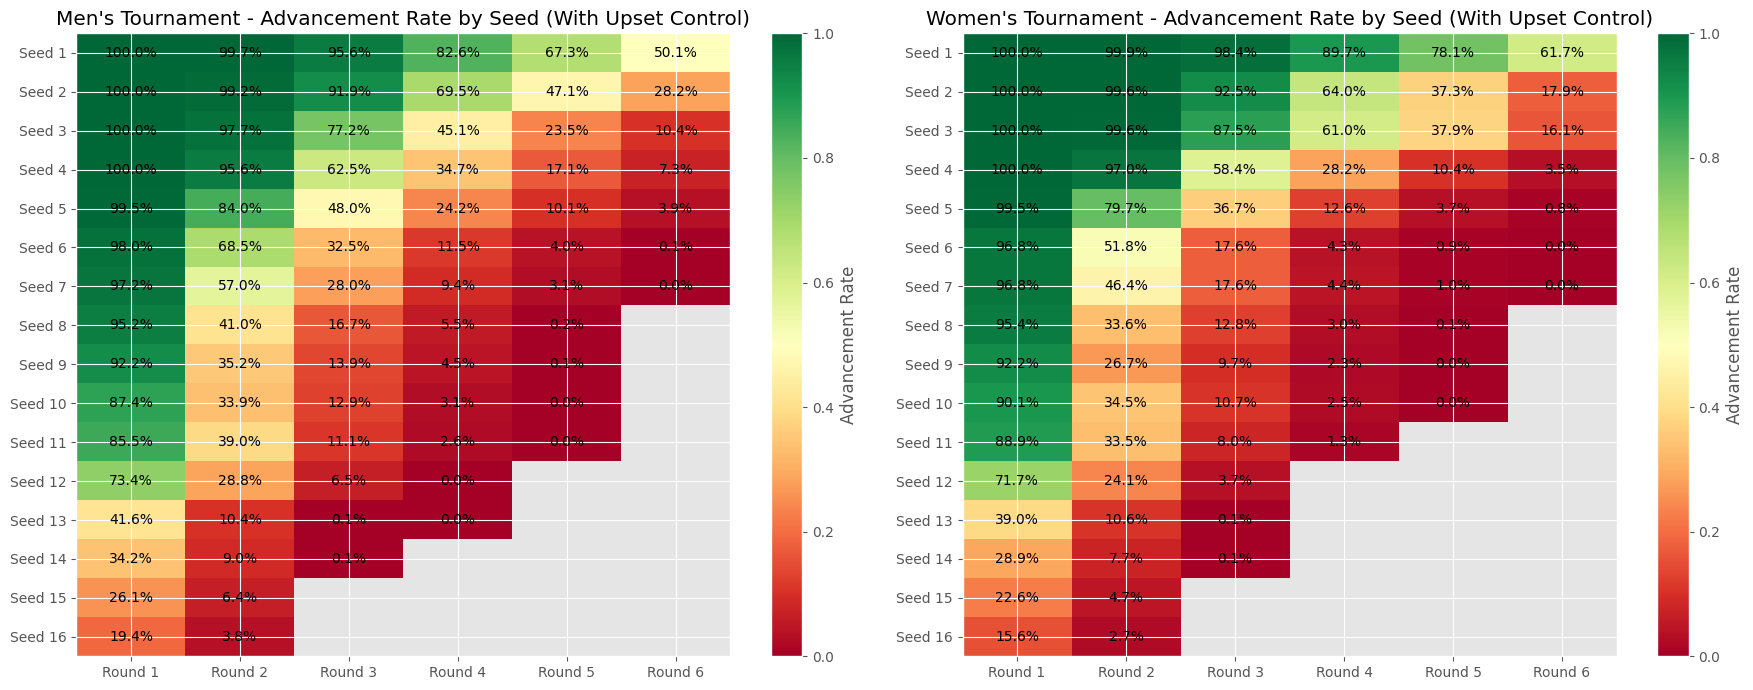


Men's Championship Seeds:
Original vs Controlled (count)
            Original  Controlled
SeedNumber                      
1              24320       25039
2              13860       14083
3               4953        5205
4               3618        3647
5               1860        1950
6                572          58
7                385          18
8                188           0
9                116           0
10                63           0
11                46           0
12                19           0

Women's Championship Seeds:
Original vs Controlled (count)
            Original  Controlled
SeedNumber                      
1              30501       30826
2               9011        8946
3               7974        8044
4               1731        1755
5                430         422
6                 77           4
7                 98           3
8                 55           0
9                 44           0
10                57           0
11                21    

In [12]:
# Load the updated submission file with controlled upsets
submission_controlled = pd.read_csv(controlled_csv_path)

# how many unique brackets per tournament
print("Controlled brackets per tournament:")
print(submission_controlled.groupby('Tournament')['Bracket'].nunique())

# Extract seed numbers for analysis (removing the region letter)
submission_controlled['SeedNumber'] = submission_controlled['Team'].str[1:].astype(int)

# Extract round information
submission_controlled['Round'] = submission_controlled['Slot'].str.extract(r'R(\d)').iloc[:,0].astype(int)

# Define a function for creating just the advancement rate heatmaps
def visualize_bracket_advancement(submission_df, men_brackets, women_brackets, title_suffix=""):
    # Analyze Men's and Women's tournaments separately
    tournaments = ['M', 'W']
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    for i, tournament in enumerate(tournaments):
        # Filter for this tournament
        tourney_data = submission_df[submission_df['Tournament'] == tournament]
        
        # First visualization: Advancement rate - how often each seed appears in each round
        seed_adv = (
            tourney_data
            .groupby(['Round', 'SeedNumber', 'Bracket'])
            .size()
            .reset_index(name='count')
            .groupby(['Round', 'SeedNumber'])
            .size()
            .reset_index(name='wins')
        )
        
        # Calculate by regions (each seed appears 4 times in Round 1)
        # Count how many regions have this seed in each round
        total_brackets = men_brackets if tournament == 'M' else women_brackets
        seed_adv['possible'] = total_brackets * 4 if seed_adv['Round'].eq(1).all() else total_brackets
        seed_adv.loc[seed_adv['Round'] > 1, 'possible'] = total_brackets
        
        # Calculate advancement rate
        seed_adv['advance_rate'] = np.minimum(seed_adv['wins'] / seed_adv['possible'], 1.0)
        
        # Pivot for easier plotting
        pivot_data = seed_adv.pivot(index='SeedNumber', columns='Round', values='advance_rate')
        
        # Plot heatmap
        cmap = plt.colormaps['RdYlGn']
        ax = axes[i]
        
        im = ax.imshow(pivot_data, cmap=cmap, aspect='auto', vmin=0, vmax=1)
        
        # Add round labels (columns)
        ax.set_xticks(np.arange(len(pivot_data.columns)))
        ax.set_xticklabels([f'Round {r}' for r in pivot_data.columns])
        
        # Add seed labels (rows)
        ax.set_yticks(np.arange(len(pivot_data.index)))
        ax.set_yticklabels([f'Seed {s}' for s in pivot_data.index])
        
        # Add text annotations with percentages
        for j in range(len(pivot_data.index)): 
            for k in range(len(pivot_data.columns)): 
                if not np.isnan(pivot_data.iloc[j, k]): 
                    text = ax.text(k, j, f'{pivot_data.iloc[j, k]:.1%}', 
                                 ha="center", va="center", color="black")
        
        # Add colorbar
        plt.colorbar(im, ax=ax, label='Advancement Rate')
        
        # Add title
        title = "Men's Tournament" if tournament == 'M' else "Women's Tournament"
        ax.set_title(f"{title} - Advancement Rate by Seed {title_suffix}")
    
    plt.tight_layout()
    return fig

# Visualize the controlled brackets (advancement rate only)
fig = visualize_bracket_advancement(
    submission_controlled, 
    MEN_BRACKETS, 
    WOMEN_BRACKETS, 
    "(With Upset Control)"
)
plt.show()

# Function to get championship seed distribution
def get_championship_seeds(df, tournament):
    return df[(df['Tournament'] == tournament) & 
              (df['Round'] == 6)]['SeedNumber'].value_counts().sort_index()

# Original men's championships
orig_m_champ = get_championship_seeds(submission, 'M')
ctrl_m_champ = get_championship_seeds(submission_controlled, 'M')

print("\nMen's Championship Seeds:")
print("Original vs Controlled (count)")
comparison_m = pd.DataFrame({
    'Original': orig_m_champ,
    'Controlled': ctrl_m_champ
})
print(comparison_m.fillna(0).astype(int))

# Original women's championships
orig_w_champ = get_championship_seeds(submission, 'W')
ctrl_w_champ = get_championship_seeds(submission_controlled, 'W')

print("\nWomen's Championship Seeds:")
print("Original vs Controlled (count)")
comparison_w = pd.DataFrame({
    'Original': orig_w_champ,
    'Controlled': ctrl_w_champ
})
print(comparison_w.fillna(0).astype(int))